Importing libraries

In [0]:
import pandas as pd

import lightgbm
from lightgbm import LGBMClassifier

from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from keras.utils import to_categorical

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Uploading dataset

In [0]:
# link to raw dataset in github
url = 'https://raw.githubusercontent.com/VANADAIN/competition/master/data.csv'
data = pd.read_csv(url)

# # uncomment if uploading locally
# data_path = '/content/data.csv'
# data = pd.read_csv(data_path)

# EDA


## Reading data

In [0]:
columns = data.columns

In [0]:
for i in columns:
  print(i)

temperature
velocity
pressure
incline
class


In [0]:
data.head(5)

,temperature,velocity,pressure,incline,class
0,5.1,3.5,1.4,0.2,Class_1
1,4.9,3.0,1.4,0.2,Class_1
2,4.7,3.2,1.3,0.2,Class_1
3,4.6,3.1,1.5,0.2,Class_1
4,5.0,3.6,1.4,0.2,Class_1


Size of the dataset


In [0]:
data.shape

(134, 5)

In [0]:
data.dtypes

temperature    float64
velocity       float64
pressure       float64
incline        float64
class           object
dtype: object

cases in each class

In [0]:
data['class'].value_counts()

Class_3    45
Class_1    45
Class_2    44
Name: class, dtype: int64

checking for missing data

In [0]:
# no missing data in dataset  --> False
data.isnull().values.any()

False

## Some visualization

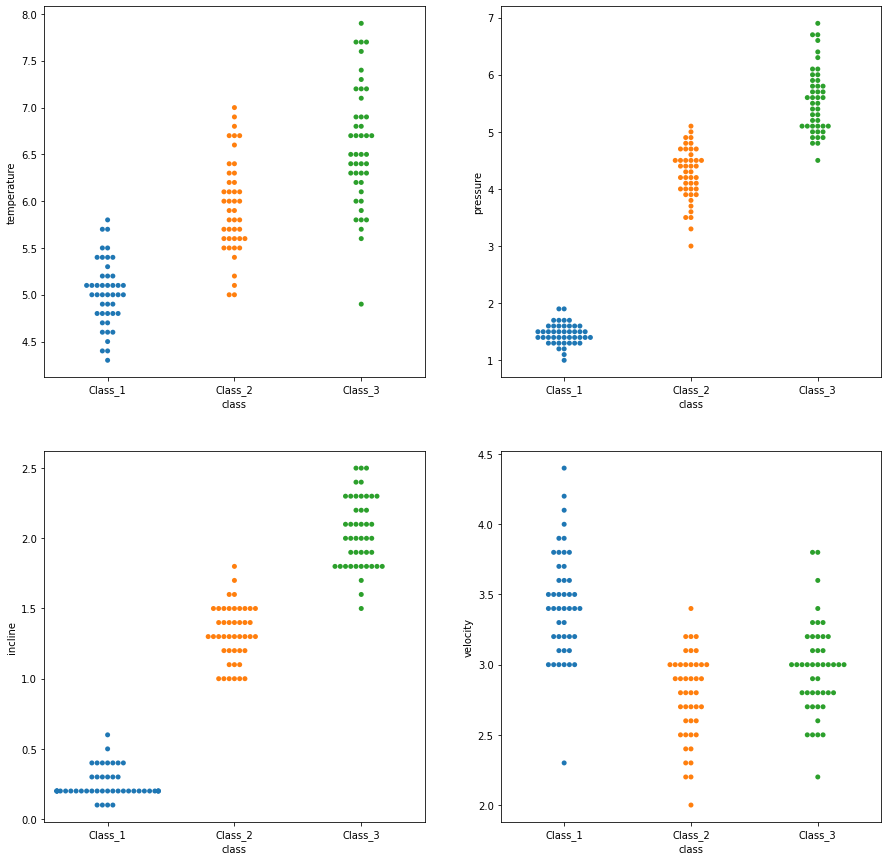

In [0]:
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(15)
sns.swarmplot(x = data['class'], y = data.temperature, ax=axs[0, 0])
sns.swarmplot(x = data['class'], y = data.pressure, ax=axs[0, 1])
sns.swarmplot(x = data['class'], y = data.incline, ax=axs[1, 0])
sns.swarmplot(x = data['class'], y = data.velocity, ax=axs[1 , 1])

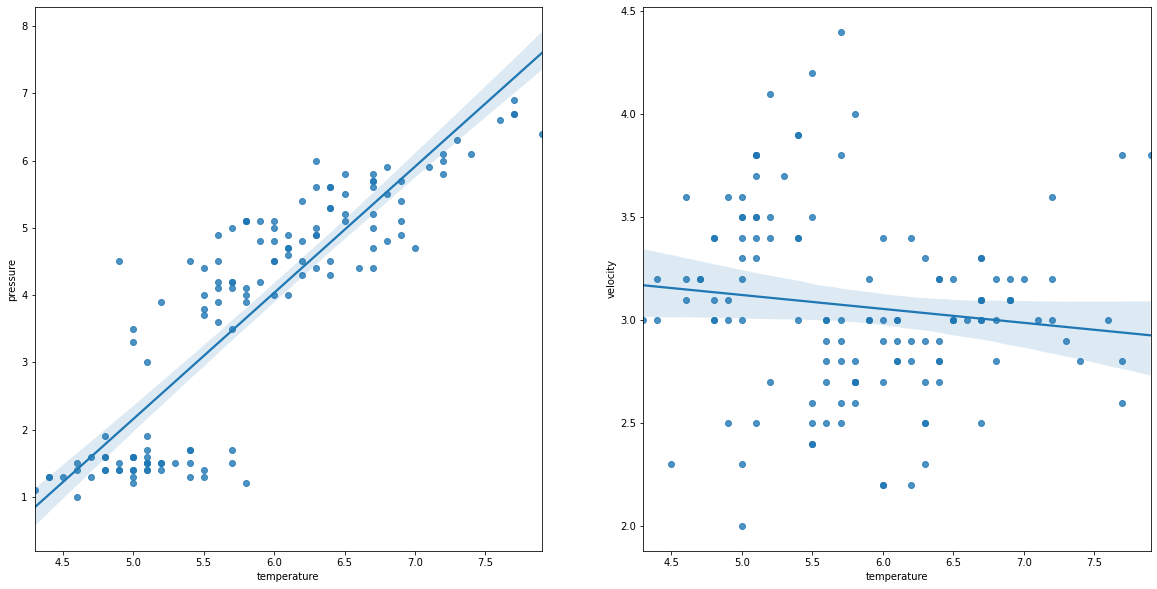

In [0]:
fig, axs = plt.subplots(ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(10)
sns.regplot(x = "temperature", y = "pressure",  data=data, ax=axs[0])
sns.regplot(x = "temperature", y = "velocity",  data=data, ax=axs[1])


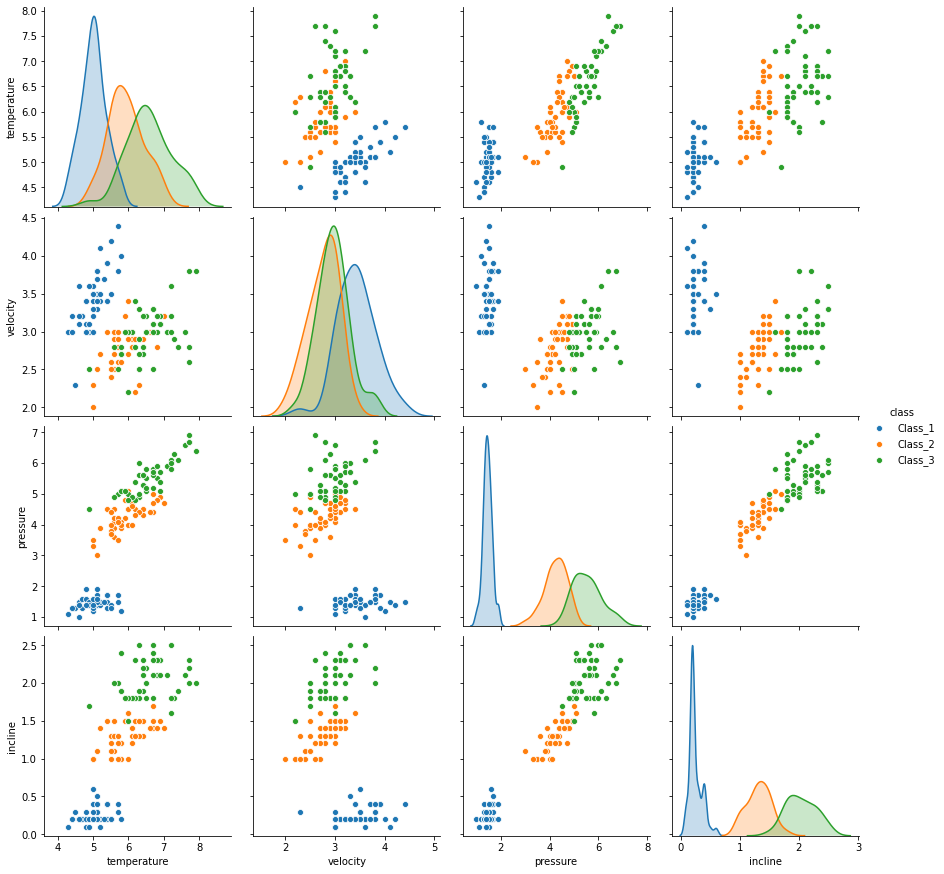

In [0]:
sns.pairplot(data, hue='class', height=3)

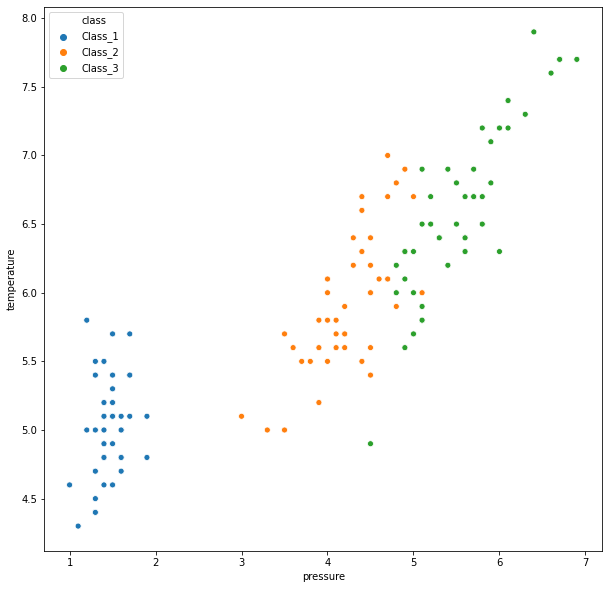

In [0]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=data['pressure'], y=data['temperature'], hue=data['class'])

# Data preparation

separating target from predictors

In [0]:

y = data['class']
X = data.drop(['class'], axis=1)


train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Building a Random Forest model

In [0]:
def model_check(l_rate, estimators):

  # define a model
  lgb = LGBMClassifier(learning_rate = l_rate, 
                     boosting_type = 'gbdt', 
                     objective = 'multiclass',
                     max_depth = 5,
                     metric = 'multi_logloss',  # aka softmax
                     num_leaves = 50,
                     n_estimators = estimators)
  # fit model
  lgb.fit(X_train, y_train) 

  # predict the class 
  y_pred = lgb.predict(X_valid)

  # accuracy of the model
  accuracy = accuracy_score(y_pred, y_valid)

  return accuracy


## Check for overfitting

In [0]:
l_rates = [0.5, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005, 0.001]
for i in l_rates:
  score = model_check(i, 50)
  print(f"Learning rate: {i} \t\t  Acc: {score}")

Learning rate: 0.5 		  Acc: 0.9259259259259259
Learning rate: 0.2 		  Acc: 0.9259259259259259
Learning rate: 0.1 		  Acc: 0.9629629629629629
Learning rate: 0.05 		  Acc: 0.9629629629629629
Learning rate: 0.04 		  Acc: 0.9629629629629629
Learning rate: 0.03 		  Acc: 0.9629629629629629
Learning rate: 0.02 		  Acc: 1.0
Learning rate: 0.01 		  Acc: 1.0
Learning rate: 0.005 		  Acc: 1.0
Learning rate: 0.001 		  Acc: 1.0


In [0]:
estimators = [i for i in range(1, 51, 5)]
for j in estimators:
  score = model_check(0.005, j)
  print(f"Estimators: {j} \t\t  Acc: {score}")

Estimators: 1 		  Acc: 0.25925925925925924
Estimators: 6 		  Acc: 1.0
Estimators: 11 		  Acc: 1.0
Estimators: 16 		  Acc: 1.0
Estimators: 21 		  Acc: 1.0
Estimators: 26 		  Acc: 1.0
Estimators: 31 		  Acc: 1.0
Estimators: 36 		  Acc: 1.0
Estimators: 41 		  Acc: 1.0
Estimators: 46 		  Acc: 1.0


Optimal


In [0]:
LEARNING_RATE = 0.005
ESTIMATORS = 25

## Final model

In [0]:
 # final model
 model = LGBMClassifier(learning_rate = LEARNING_RATE, 
                     boosting_type = 'gbdt', 
                     objective = 'multiclass',
                     metric = 'multi_logloss',  # aka softmax
                     num_leaves = 31,
                     n_estimators = ESTIMATORS, 
                     silent=False)

In [0]:
# no pre/post processing
my_pipeline = Pipeline(steps=[('model', model)])


## Cross-validation and tree plotting

In [0]:
final_scores = cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='accuracy')
final_scores

array([0.92592593, 0.96296296, 0.92592593, 0.96296296, 1.        ])

**Cross-Validation Score**

In [0]:
final_scores.mean()

0.9555555555555555

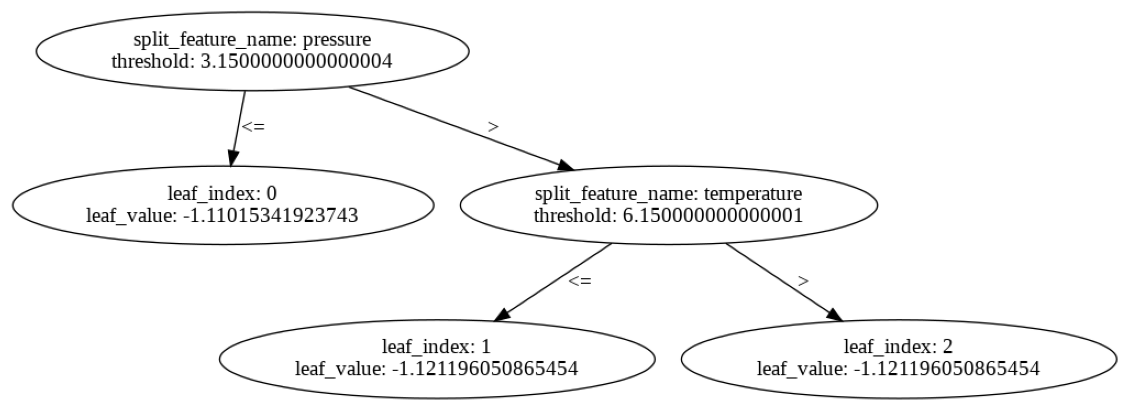

In [0]:
# fitting once to be able to plot
model.fit(X_train, y_train)

plot_tree = lightgbm.plot_tree(booster = model, figsize=(20, 30))

# Building Logistic Regression model

## Data Preparation

In [0]:
# converting dataframe to array
x_values = X.values
scaler = StandardScaler()
norm_X = scaler.fit_transform(x_values)

encoding classes

In [0]:
enc = LabelEncoder()
norm_y = enc.fit_transform(y)
norm_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [0]:
norm_X_train, norm_X_val, norm_y_train, norm_y_val = train_test_split( norm_X, norm_y, test_size = 0.2, random_state = 0)

## Defining a model

In [0]:
LR = LogisticRegression(C=0.01, solver='lbfgs').fit(norm_X_train, norm_y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
log_y_pred = LR.predict(norm_X_val)
log_y_pred

array([1, 1, 0, 0, 2, 0, 1, 1, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1, 0, 0, 0, 0,
       2, 1, 0, 0, 1])

In [0]:
accuracy = accuracy_score(log_y_pred, log_y_val)
accuracy

0.8518518518518519

# Building SVM model

In [0]:
svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
svm_pred = svm_clf.predict(X_valid)
svm_pred

array(['Class_2', 'Class_2', 'Class_1', 'Class_1', 'Class_3', 'Class_1',
       'Class_2', 'Class_2', 'Class_2', 'Class_3', 'Class_2', 'Class_3',
       'Class_3', 'Class_2', 'Class_1', 'Class_3', 'Class_3', 'Class_3',
       'Class_1', 'Class_1', 'Class_1', 'Class_1', 'Class_3', 'Class_2',
       'Class_1', 'Class_1', 'Class_3'], dtype=object)

In [0]:
accuracy = accuracy_score(svm_pred, y_valid)
accuracy

0.9629629629629629

## Cross-validation

In [0]:
svm_pipeline = Pipeline(steps=[('model', svm_clf)])
svm_scores = cross_val_score(svm_pipeline, X, y,
                              cv=5,
                              scoring='accuracy')
svm_scores.mean()

0.9703703703703702

# Building KNN model (K-nearest neighbors)

## trying for different k 

In [0]:
for k in range(1, 10):
#Train Model and Predict using normalized data
  neigh = KNeighborsClassifier(n_neighbors = k).fit(norm_X_train, norm_y_train)
  knn_pred = neigh.predict(norm_X_val)
  accuracy = accuracy = accuracy_score(knn_pred, norm_y_val)
  print("k= " + str(k) + '       accuracy= ' + str(accuracy))


k= 1       accuracy= 0.8888888888888888
k= 2       accuracy= 0.8518518518518519
k= 3       accuracy= 0.8888888888888888
k= 4       accuracy= 0.8518518518518519
k= 5       accuracy= 0.9629629629629629
k= 6       accuracy= 0.9629629629629629
k= 7       accuracy= 0.9629629629629629
k= 8       accuracy= 0.9629629629629629
k= 9       accuracy= 0.9629629629629629


In [0]:
knn_model = KNeighborsClassifier(n_neighbors = 5)

In [0]:
svm_pipeline = Pipeline(steps=[('model', knn_model)])
knn_scores = cross_val_score(svm_pipeline, norm_X, norm_y,
                              cv=5,
                              scoring='accuracy')
knn_scores.mean()

0.9555555555555555

# Building keras model

In [0]:
# number of classes
num_classes = 3

keras_model = Sequential()



In [0]:
norm_y_train = to_categorical(norm_y_train)
norm_y_val = to_categorical(norm_y_val)

In [0]:
# First Hidden Layer
keras_model.add(Dense(3, activation='relu', input_dim=4))

# Second  Hidden Layer
keras_model.add(Dense(3, activation='relu'))

# Output Layer
keras_model.add(Dense(num_classes, activation='softmax'))

# Compiling the neural network
keras_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


In [0]:
keras_model.fit(norm_X_train, norm_y_train,
          batch_size=10,
          epochs=150,
          validation_split = 0.2)

Epoch 1/150
9/9 [==============================] - 0s 14ms/step - loss: 1.1975 - accuracy: 0.2471 - val_loss: 1.1597 - val_accuracy: 0.2273
Epoch 2/150
9/9 [==============================] - 0s 5ms/step - loss: 1.1572 - accuracy: 0.2941 - val_loss: 1.1477 - val_accuracy: 0.2273
Epoch 3/150
9/9 [==============================] - 0s 5ms/step - loss: 1.1536 - accuracy: 0.2941 - val_loss: 1.1374 - val_accuracy: 0.2273
Epoch 4/150
9/9 [==============================] - 0s 6ms/step - loss: 1.1293 - accuracy: 0.2941 - val_loss: 1.1276 - val_accuracy: 0.2727
Epoch 5/150
9/9 [==============================] - 0s 5ms/step - loss: 1.1058 - accuracy: 0.3059 - val_loss: 1.1177 - val_accuracy: 0.3182
Epoch 6/150
9/9 [==============================] - 0s 5ms/step - loss: 1.0925 - accuracy: 0.3176 - val_loss: 1.1082 - val_accuracy: 0.3182
Epoch 7/150
9/9 [==============================] - 0s 5ms/step - loss: 1.0812 - accuracy: 0.3176 - val_loss: 1.0992 - val_accuracy: 0.3182
Epoch 8/150
9/9 [=========

In [0]:
keras_pred = keras_model.evaluate(norm_X_val, norm_y_val, verbose = 0)
keras_pred

[0.3264961242675781, 0.8888888955116272]